# Batch HSRI Tutorial

Batch Hypervolume Sharpe Ratio Indicator (qHSRI) is a method for picking a batch of query points during Bayesian Optimisation. It makes use of the Sharpe Ratio, a portfolio selection method used in investment selection to carefully balance risk and reward.

This tutorial will cover the main points of how this algorithm works.

First we will set up our problem and get our initial datapoints. We will use the scaled Branin objective.

In [1]:

import tensorflow as tf
import matplotlib.pyplot as plt

from trieste.objectives import scaled_branin
from trieste.objectives.utils import mk_observer
from trieste.space import Box
import trieste

tf.random.set_seed(1)

# Create the observer
observer = mk_observer(scaled_branin)

# Define Search space
search_space = Box([0,0], [1,1])

# Set initial number of query points
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

2022-08-05 10:43:18.789469: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 10:43:18.789516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-05 10:43:20.982997: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-05 10:43:20.983127: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-05 10:43:20.983135: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-05 10:43:20.983151: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running 

We can now fit a GP to our initial data.

In [2]:
from trieste.models.gpflow import GaussianProcessRegression, build_gpr

# Set up model
gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model)

2022-08-05 10:43:21.195232: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Now consider how we might want to select a batch of $q$ query points to observe. It would be useful for some of these to be "safe bets" that we think are very likely to provide an improvement. It would also be valuable for some of these to be sampling parts of the space that we have no idea what the expected observed value is (i.e. high variance). This problem is very similar to that encountered in building finance portfolios, where you want a mix of high  risk/high reward and low risk/low reward assets. You would also want to know how much of your total capital to invest in each asset.

We can sample from the model to determine the mean and standard deviation of points. For example if we randomly sample 1000 points from the space, we can then plot the mean and standard deviation. As we actually want to maximise standard deviation, we will multiply by -1 once sampled

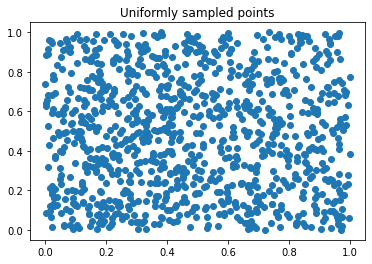

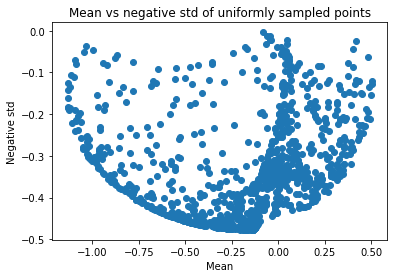

In [3]:
uniform_points = tf.random.uniform([1000,2], dtype="float64")
uniform_pts_mean, uniform_pts_var = model.predict(uniform_points)
uniform_pts_std = -tf.sqrt(uniform_pts_var)

plt.scatter(uniform_points[:, 0], uniform_points[:, 1])
plt.title("Uniformly sampled points")
plt.show()
plt.close()

plt.scatter(uniform_pts_mean, uniform_pts_std)
plt.title("Mean vs negative std of uniformly sampled points")
plt.xlabel("Mean")
plt.ylabel("Negative std")
plt.show()



Since we only want the best points in terms of the risk reward tradeoff, we want points that have low means and high standard deviations. So we remove any points that are dominated by another point. A point `a` is dominated by another point `b` if `b.mean` <= `a.mean` and `b.std` >= `a.std`.

There is a function in trieste that lets us calculate this non-dominated set. Let's find the non-dominated points and plot them on the above chart.

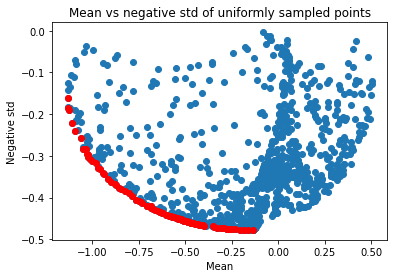

There are 93 non-dominated points


In [4]:
from trieste.acquisition.multi_objective.dominance import non_dominated

uniform_non_dominated = non_dominated(tf.concat([uniform_pts_mean, uniform_pts_std], axis=1))[0]

plt.scatter(uniform_pts_mean, uniform_pts_std)
plt.scatter(uniform_non_dominated[:,0], uniform_non_dominated[:,1], c="r")
plt.title("Mean vs negative std of uniformly sampled points")
plt.xlabel("Mean")
plt.ylabel("Negative std")
plt.show()

print(f"There are {len(uniform_non_dominated)} non-dominated points")

We can see that there's only a few non-dominated points to choose from the select the next batch. This set of non-dominated points is the Pareto front in the optimisation task of minimising mean and maximising standard deviation.

This means we can improve on this by using optimisation rather than random sampling to pick the points that we will select our batch from. We can use the NSGA-II multi-objective optimisation method from the pymoo library to find the Pareto front.

First we must define the problem as a pymoo problem.

In [5]:
import numpy as np
import pymoo

class MeanStdTradeoff(pymoo.core.problem.Problem):

    def __init__(self, probabilistic_model, search_space):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array(search_space.lower), xu=np.array(search_space.upper))
        self.probabilistic_model = probabilistic_model

    def _evaluate(self, x, out, *args, **kwargs):
        mean,var = self.probabilistic_model.predict_y(x)
        # Flip sign on std so that minimising is increasing std
        std = -1*np.sqrt(np.array(var))
        out["F"] = np.concatenate([np.array(mean), std], axis=1)

NSGA-II is a genetic algorithm, and so we need to define a population size and number of generations.

In [6]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

problem = MeanStdTradeoff(model, search_space)
algorithm = NSGA2(pop_size=500)
result = minimize(problem, algorithm, ('n_gen', 200), seed=1, verbose=False)
optimised_points, optimised_mean_std = result.X,result.F

Now we can plot the points that have been optimised for mean and standard deviation, and their means and stds.

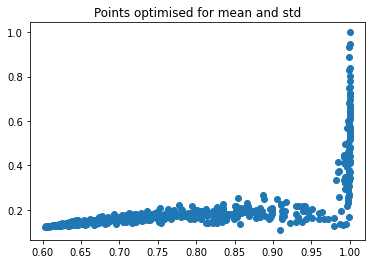

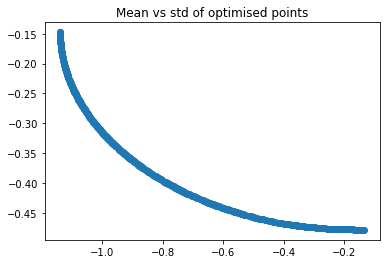

In [7]:
plt.scatter(result.X[:,0], result.X[:,1])
plt.title("Points optimised for mean and std")
plt.show()

plt.scatter(result.F[:,0], result.F[:,1])
plt.title("Mean vs std of optimised points")
plt.show()

We can check the non-dominated points again, and see that this is a great improvement.

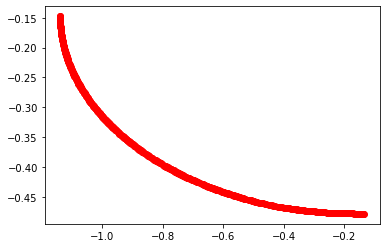

There are 500 non-dominated points


In [8]:
optimised_non_dominated = non_dominated(result.F)[0]
plt.scatter(optimised_non_dominated[:,0], optimised_non_dominated[:,1], c="r")
plt.show()
print(f"There are {len(optimised_non_dominated)} non-dominated points")

The question now is, how do we sample points from this Pareto set such that we get an optimal mix of low mean and high standard deviation points.

That's where the Sharpe Ratio is used.

The portfolio with the maximum Sharpe ratio is defined as:

$$ \max_{x \in [0,1]^n} h(x) = {{r^{T}x-r_{f}} \over {\sqrt{x^{T}Qx}}} \;\;\; s.t  \sum^{n}_{i=1}x_i = 1 $$

where $x_i$ are weights for each asset $i$, $r_i$ is the expected return of asset $i$ and $Q_{i,j} is the covariance of assets $i$ and $j$. $r_f$ is a risk free asset, and we will assume this does not exist in this case. Note that weighting assets with high expected rewards will increase the Sharpe ratio, as will weighting assets with low covariance.

This problem can be converted into a quadratic programming problem.

$$ \min_{y \in \reals^n} g(y) = y^TQy $$

$$ s.t \sum^{n}_{i=1}r_iy_i = 1 $$

$$ y_i \geq 0, i = 1,..,n $$

If we want to use this formula then we need to find a way to compute $r$ and $Q$. For this we use hypervolumes. Hypervolumes in this context are the volumes dominated by a point with respect to a reference point.

We will set a reference point and lower bound here. The lower bound is just used for scaling, so does not matter too much, but the selection of the reference point does affect the result. We set it to the max value in each dimension + 20% of the range of that dimension. We plot these points with the Pareto front.

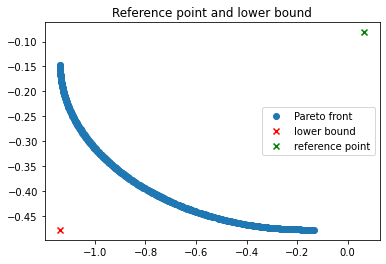

In [9]:
# Set lower bound
lower_bound = [float(min(optimised_non_dominated[:, 0])), float(min(optimised_non_dominated[:,1]))]

# Calculate suitable reference point
u_deltas = [(float(max(optimised_non_dominated[:, i])) - float(min(optimised_non_dominated[:, i]))) * 0.2 for i in range(2)]
reference_point = [float(max(optimised_non_dominated[:,i])) + u_deltas[i] for i in range(2)]

plt.scatter(optimised_non_dominated[:,0], optimised_non_dominated[:,1], label="Pareto front")
plt.scatter(lower_bound[0], lower_bound[1], c="r", label="lower bound", marker="x")
plt.scatter(reference_point[0], reference_point[1], c="g", label="reference point", marker="x")
plt.legend()
plt.title("Reference point and lower bound")
plt.show()

We can then visualise the hypervolume of the first point in the Pareto set.

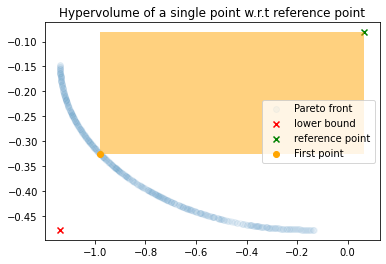

In [10]:
first_point = optimised_non_dominated[250]

# Caculate the size of the rectangle
width = reference_point[0] - first_point[0]
height = reference_point[1] - first_point[1]

# Highlight point and plot rectangle
plt.scatter(optimised_non_dominated[:,0], optimised_non_dominated[:,1], label="Pareto front", alpha=0.04)
plt.scatter(lower_bound[0], lower_bound[1], c="r", label="lower bound", marker="x")
plt.scatter(reference_point[0], reference_point[1], c="g", label="reference point", marker="x")
hypervolume_rectangle = plt.Rectangle(first_point, width, height, fc="orange", alpha=0.5)
plt.gca().add_patch(hypervolume_rectangle)
plt.scatter(first_point[0], first_point[1], c="orange", label="First point")
plt.legend()
plt.title("Hypervolume of a single point w.r.t reference point")
plt.show()



This area is the hypervolume for point 250, and is used as $r_{250}$ (after scaling).

For two points the value $p_{i,j}$ is the union of the hypervolumes of assets $i$ and $j$. For example:

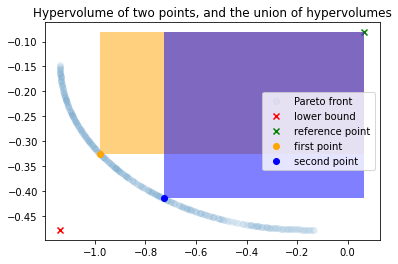

In [11]:
second_point = optimised_non_dominated[251]

# Caculate the size of the rectangle
width2 = reference_point[0] - second_point[0]
height2 = reference_point[1] - second_point[1]

# Highlight point and plot rectangle
plt.scatter(optimised_non_dominated[:,0], optimised_non_dominated[:,1], label="Pareto front", alpha=0.04)
plt.scatter(lower_bound[0], lower_bound[1], c="r", label="lower bound", marker="x")
plt.scatter(reference_point[0], reference_point[1], c="g", label="reference point", marker="x")
hypervolume_rectangle = plt.Rectangle(first_point, width, height, fc="orange", alpha=0.5)
plt.gca().add_patch(hypervolume_rectangle)
hypervolume_rectangle2 = plt.Rectangle(second_point, width2, height2, fc="blue", alpha=0.5)
plt.gca().add_patch(hypervolume_rectangle2)
plt.scatter(first_point[0], first_point[1], c="orange", label="first point")
plt.scatter(second_point[0], second_point[1], c="blue" ,label="second point")
plt.legend()
plt.title("Hypervolume of two points, and the union of hypervolumes")
plt.show()


The area of the union $p_{i,j}$ can be calculated as the reference point minus the max value of the pair of points in each dimension, multiplied together. This is then scaled by the distance between the reference point and the lower bound in each dimension. Formally

$$ p_{i,j}(l,u) = \frac{\prod^{d}_{k=1}(u_k - \max{(a^{(i)}_k}, {a^{(j)}_k}))}{\prod^{d}_{k=1}(u_k-l_k)}$$

where the number of dimension, $d=2$. 

We can then use these values to calculate $Q$ as

$$ Q = P - rr^T $$
where $r = p_i = p_{i,i}$ is the diagonal of $P$.

In [12]:
front_size = optimised_non_dominated.shape[0]
front_dims = optimised_non_dominated.shape[1]

p = np.zeros([front_size, front_size])

# Calculate denominator value for p matrix elements 
denominator = 1
for i in range(front_dims):
    denominator *= reference_point[i] - lower_bound[i]

# Fill entries of p
for i in range(front_size):
    for j in range(front_size):
        p[i,j] = ((reference_point[0] - max(optimised_non_dominated[i, 0],optimised_non_dominated[j, 0])) * ([1] - max(optimised_non_dominated[i, 1], optimised_non_dominated[j, 1])))

p = p / denominator

# Calculate q
p_diag = np.expand_dims(np.diagonal(p), axis=1)
q = p - np.dot(p_diag, np.transpose(p_diag))

We can then form the quadratic programming problem. We use the qp solver from the `cvxopt` library for this. This solver solves the problem

$$ minimize \;\;\; (1/2)x^TPx + q^Tx $$
$$ s.t \; \;\;\;\;Gx \preceq h $$
$$ \;\;\;\;\;\;\;\;\;Ax = b $$

where $\preceq$ is an elementwise inequality. We need to fit our problem into this format. We can do this as

$$ P = Q $$
$$ q = [0,...,0]^T $$
$$ G = -I $$
$$ h = [0,...,0]^T $$
$$ A = r^T $$
$$ b = 1 $$

Following these assignments we can run the quadratic program solver.

In [13]:
from cvxopt import matrix, solvers
P = matrix(np.array(q))
q = matrix(np.zeros([front_size, 1]))
G = matrix(-1*np.eye(front_size))
h = matrix(np.zeros([front_size, 1]))
A = matrix(np.transpose(p_diag))
b = matrix(np.ones([1,1]))
optim = solvers.qp(P=P,q=q,G=G,h=h,A=A,b=b)

     pcost       dcost       gap    pres   dres
 0: -3.4264e-01 -7.0650e-01  4e-01  3e-15  2e+01
 1: -3.4264e-01 -3.4667e-01  4e-03  4e-16  2e-01
 2: -3.4265e-01 -3.4278e-01  1e-04  1e-16  8e-03
 3: -3.4265e-01 -3.4267e-01  2e-05  2e-16  1e-03
 4: -3.4266e-01 -3.4266e-01  7e-06  2e-16  1e-04
 5: -3.4266e-01 -3.4266e-01  1e-06  5e-18  2e-05
 6: -3.4266e-01 -3.4266e-01  2e-07  4e-16  6e-07
 7: -3.4266e-01 -3.4266e-01  3e-08  4e-16  6e-08
Optimal solution found.


The output of this optimisation is $y^*$ We can then calculate $x^*$ as
$$ x_i^* = \frac{y_i^*}{\sum^{n}_{j=1}y_j}

In [14]:
# Extract y*
y_star = np.array(optim["x"])
# Calculate x*
x_star = y_star / np.sum(y_star)

We now have $x^*$, the optimal set of weights for the assets. We now need to choose a batch using these weights. If we had noisy observations we may want to just divide the elements of the batch out proportionally based on weight, as we would then potentially have repeats. For a noiseless problem, we can just take the $q$ most highly weighted assets.

In [15]:
batch_size = 5

# Create id array to keep track of points
id_arr = np.expand_dims(np.arange(front_size), axis=1)

# Stitch id array, x_star and the front together
stitched_array = np.concatenate([id_arr, x_star, np.array(optimised_non_dominated)], axis=1)

# Sort array by x_star descending
sorted_array = stitched_array[stitched_array[:,0].argsort()[::-1]]

samples = sorted_array[:batch_size, 2:]
sample_ids = sorted_array[:batch_size, 0].astype(int)

Now we can see which points we selected on the Pareto front

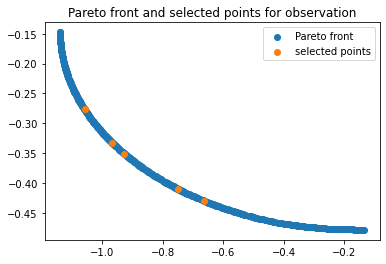

In [16]:
plt.scatter(optimised_non_dominated[:,0], optimised_non_dominated[:,1], label="Pareto front")
plt.scatter(samples[:,0], samples[:,1], label="selected points")
plt.legend()
plt.title("Pareto front and selected points for observation")
plt.show()

These points can then be observed and the model updated. This aquisition method has been implemented in `trieste` as an acquisition rule, `trieste.acquisition.rule.BatchHypervolumeRatioIndicator`.